# Calibration of Epidemic Models to Data with Epydemix - Part 2

In this second part of the tutorial, we will explore more advanced calibration features. Our primary focus will be on the ABC-SMC algorithm, as it is the most flexible and powerful method available. However, many of the concepts and techniques discussed can also be applied to other calibration algorithms.

Let's import the needed packages:

In [10]:
from scipy import stats 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
from epydemix import load_predefined_model, simulate
from epydemix.visualization import plot_posterior_distribution
from epydemix.calibration import ABCSampler
from epydemix.utils import compute_simulation_dates
from epydemix.visualization import plot_quantiles, plot_posterior_distribution_2d

import seaborn as sns   
colors = sns.color_palette("Dark2")

Before starting we import data and define the model that we used in part 1 of the tutorial:

In [ ]:
# import data and divide data into calibration and projection periods
data = pd.read_csv('./data/incidence_data.csv')
data["date"] = pd.to_datetime(data["date"])
data_calibration = data.iloc[:-40]
data_projection = data.iloc[-40:]

# model 
model = load_predefined_model("SIR")
model.import_epydemix_population(population_name="Indonesia")

# initial conditions (we assume fully S population except for 0.05% infected individual across age groups)
initial_conditions = {"Susceptible": model.population.Nk - (model.population.Nk * 0.05 / 100).astype(int), 
                      "Infected": (model.population.Nk * 0.05/100).astype(int),
                      "Recovered": np.zeros(len(model.population.Nk))}

# simulation dates 
simulation_dates_calibration = compute_simulation_dates(start_date=data_calibration.date.values[0], 
                                                        end_date=data_calibration.date.values[-1])
simulation_dates_projection = compute_simulation_dates(start_date=data_calibration.date.values[0], 
                                                        end_date=data_projection.date.values[-1])

# simulation parameters
parameters = {"initial_conditions_dict": initial_conditions,
              "epimodel": model, 
              "start_date": data_calibration.date.values[0],
              "end_date": data_calibration.date.values[-1]}

# priors
priors = {"transmission_rate": stats.uniform(0.010, 0.020), 
          "recovery_rate": stats.uniform(0.15, 0.1)}

# wrapper function
def simulate_wrapper(parameters): 
    results = simulate(**parameters)
    return {"data": results.transitions["Susceptible_to_Infected_total"]}

# initialize the ABCSampler object
abc_sampler = ABCSampler(simulation_function=simulate_wrapper, 
                         priors=priors, 
                         parameters=parameters, 
                         observed_data=data_calibration["data"].values)

## 1. ABC-SMC Perturbation Kernels

An important aspect of the ABC-SMC algorithm are pertubation kernels. Perturbation kernels in ABC-SMC are probability distributions used to introduce small random variations to parameter values during the iterative sampling process, allowing the algorithm to explore the parameter space more effectively while maintaining diversity in the population of particles.

By default, in Epydemix, continuous parameters use component-wise perturbation normal perturbation kernels, with the standard deviation estimated as twice the empirical standard deviation of the previous generation of particles ([Filippi et al. 2012](https://core.ac.uk/download/1718342.pdf)). Discrete parameters, on the other hand, utilize a discrete jump transition kernels.

Users can define their own custom perturbation kernels by implementing the abstract class `Perturbation`. Below, we provide a simple example where we create a component-wise uniform perturbation kernel whose width is estimated from the previous generation of particles:

In [ ]:
from epydemix.utils import Perturbation

class UniformPerturbation(Perturbation):
    def __init__(self, param_name, scale=0.1):
        super().__init__(param_name)
        self.scale = scale

    def propose(self, x):
        """Propose a new value by adding scaled noise (with positive constraint)."""
        return np.random.uniform(x - self.scale, x + self.scale)

    def pdf(self, x, center):
        """Evaluate the PDF of the kernel."""
        return 1 / (2 * self.scale)

    def update(self, particles, weights, param_names):
        """Update the scale of the kernel based on the previous generation of particles."""
        index = param_names.index(self.param_name)
        values = particles[:, index]
        self.scale = 0.5 * (np.max(values) - np.min(values))


This user-defined perturbation kernel can then be used in the ABC-SMC algorithm by specifying to which parameter must be applied:

In [ ]:
results_uniform = abc_sampler.calibrate(strategy="smc", 
                    num_particles=100, 
                    num_generations=5,
                    perturbations={
                        "transmission_rate": UniformPerturbation("transmission_rate"), 
                        "recovery_rate": UniformPerturbation("recovery_rate")
                    })

results_abc_smc = abc_sampler.calibrate(strategy="smc", 
                    num_particles=100, 
                    num_generations=5)

In [ ]:
ax = plot_posterior_distribution(results_uniform.get_posterior_distribution(), "transmission_rate", kind="kde", title="Transmission rate", color=colors[0], label="Uniform Perturbation")
ax = plot_posterior_distribution(results_abc_smc.get_posterior_distribution(), "transmission_rate", kind="kde", title="Transmission rate", color=colors[1], label="Default Perturbation", ax=ax)
ax.legend()

We can also test the evolution of the posterior distributions in different generations: 

In [ ]:
fig, ax = plt.subplots(dpi=300)
for generation, color in zip(range(5), sns.color_palette("Greens", n_colors=6)): 
    plot_posterior_distribution(results_uniform.get_posterior_distribution(generation=generation), 
                                parameter="transmission_rate", ax=ax, kind="kde", color=color, label="Generation %d" % (generation+1))
ax.legend() 

## 2. Running Projections

After calibrating the models, it is often useful to run projections into the future to explore how the epidemic might evolve. In **Epydemix**, this can be achieved using the `run_projections` method of the `CalibrationResults` object.

In this tutorial, we previously performed the calibration over a shorter time frame to fit the model to the observed data. Once calibrated, we will use the `run_projections` method of the `CalibrationResults` object to project the epidemic's trajectory over the remaining period, providing insights into possible future outcomes.

In [ ]:
# create projection parameters
projection_parameters = parameters.copy()
projection_parameters["end_date"] = data_projection.date.values[-1]

# run projections
results_abc_smc = abc_sampler.run_projections(projection_parameters)

We finally plot the results, in terms of median and 90% confidence intervals of number of infected over time during both the calibration and projection phase:

In [ ]:
# plot the projections
df_quantiles_calibration = results_abc_smc.get_calibration_quantiles(simulation_dates_calibration)
df_quantiles_projections = results_abc_smc.get_projection_quantiles(simulation_dates_projection)

fig, ax = plt.subplots(dpi=300, figsize=(10, 3))
plot_quantiles(df_quantiles_projections, columns="data", data=data, ax=ax, colors=colors[0], show_legend=True, show_data=True, labels=["New Infections, Projections"])
plot_quantiles(df_quantiles_calibration, columns="data", data=data_calibration, ax=ax, colors=colors[1], show_legend=False, show_data=True);

## 3. Calibration of External Models

Finally, we show how external models can be calibrated using `epydemix.calibration` functions. For this example, we will consider an external stochastic implementation of the SIR model (single population, no age groups).

In [ ]:
from external_models.my_stochastic_sir import stochastic_sir

The pipeline is the same as the above, with the only difference that the wrapper function will be built around `stochastic_sir`

In [3]:
# import data
data = pd.read_csv('./data/incidence_data.csv', parse_dates=["date"])

# priors
priors = {"beta": stats.uniform(0.15, 0.30), 
          "mu": stats.uniform(0.15, 0.1)}

# simulation parameters
N = 282353643 # population of Indonesia
parameters = {"S_t0": N - 150000,
              "I_t0": 150000,
              "R_t0": 0,
              "N": N,
              "timesteps": len(data)}

# wrapper function
def simulate_wrapper(parameters): 
    results = stochastic_sir(**parameters)
    return {"data": results["incidence"]}

# initialize the ABCSampler object
abc_sampler = ABCSampler(simulation_function=simulate_wrapper, 
                         priors=priors, 
                         parameters=parameters, 
                         observed_data=data["data"].values)

We run the calibration of the external model and we plot the fitted curves of new infections and posterior distributions of free parameters

In [4]:
results = abc_sampler.calibrate(strategy="smc", 
                    num_particles=100, 
                    num_generations=5)


Starting ABC-SMC with 100 particles and 5 generations

Generation 1/5 (epsilon: inf)
	Accepted 100/100 (acceptance rate: 100.00%)
	Elapsed time: 00:00:00

Generation 2/5 (epsilon: 2077780.238424)
	Accepted 100/158 (acceptance rate: 63.29%)
	Elapsed time: 00:00:02

Generation 3/5 (epsilon: 1451354.748815)
	Accepted 100/307 (acceptance rate: 32.57%)
	Elapsed time: 00:00:02

Generation 4/5 (epsilon: 908681.944234)
	Accepted 100/297 (acceptance rate: 33.67%)
	Elapsed time: 00:00:02

Generation 5/5 (epsilon: 664780.955224)
	Accepted 100/455 (acceptance rate: 21.98%)
	Elapsed time: 00:00:02


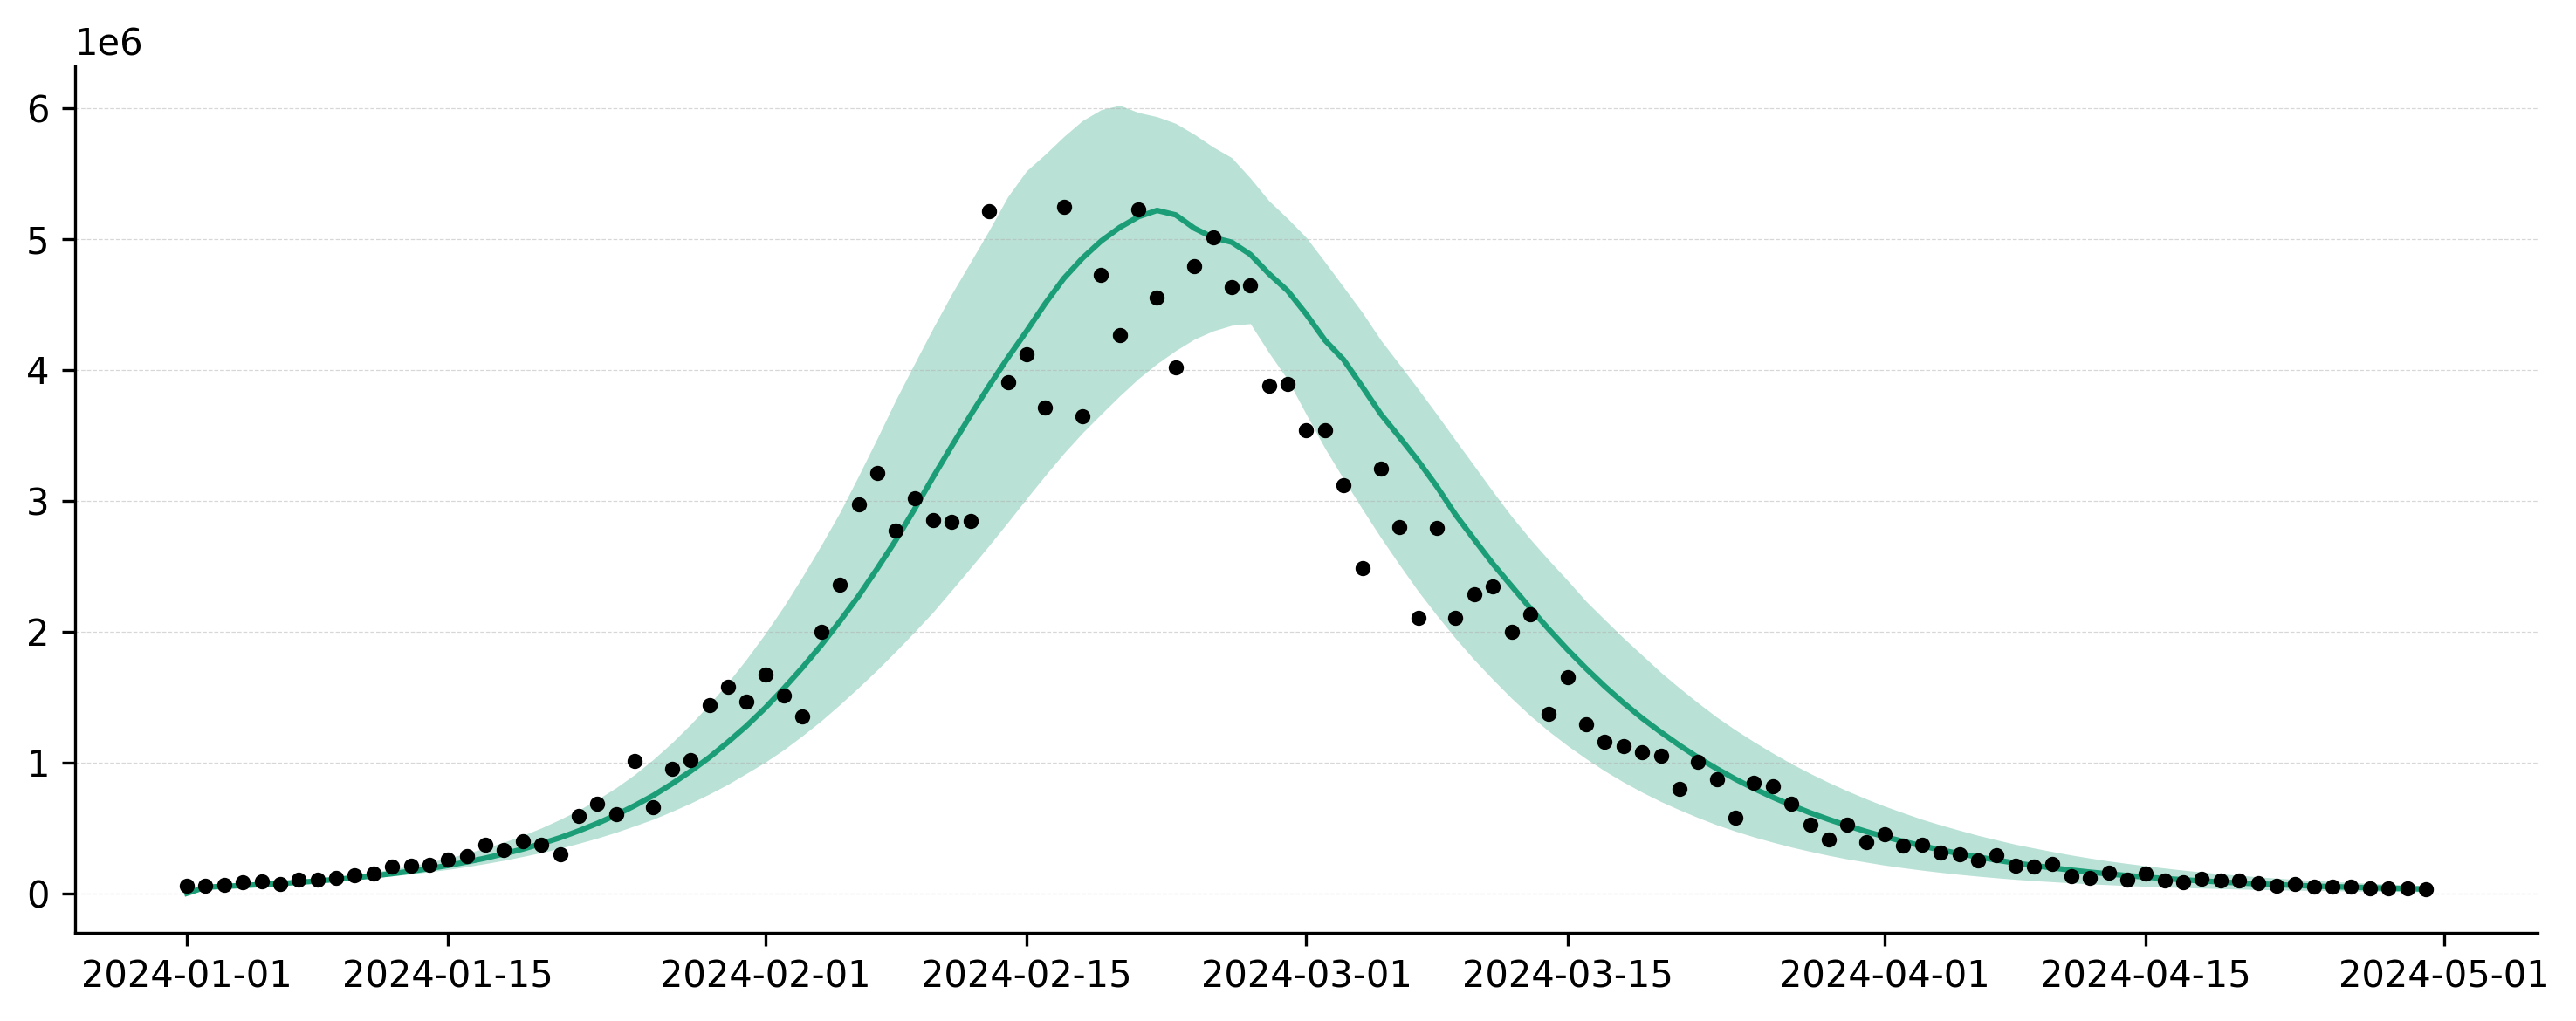

In [8]:
df_quantiles_calibration = results.get_calibration_quantiles(data["date"])
plot_quantiles(df_quantiles_calibration, columns="data", data=data, colors=colors[0], show_legend=False, show_data=True);

<Axes: title={'center': 'Joint Distribution\nbeta vs mu'}, xlabel='beta', ylabel='mu'>

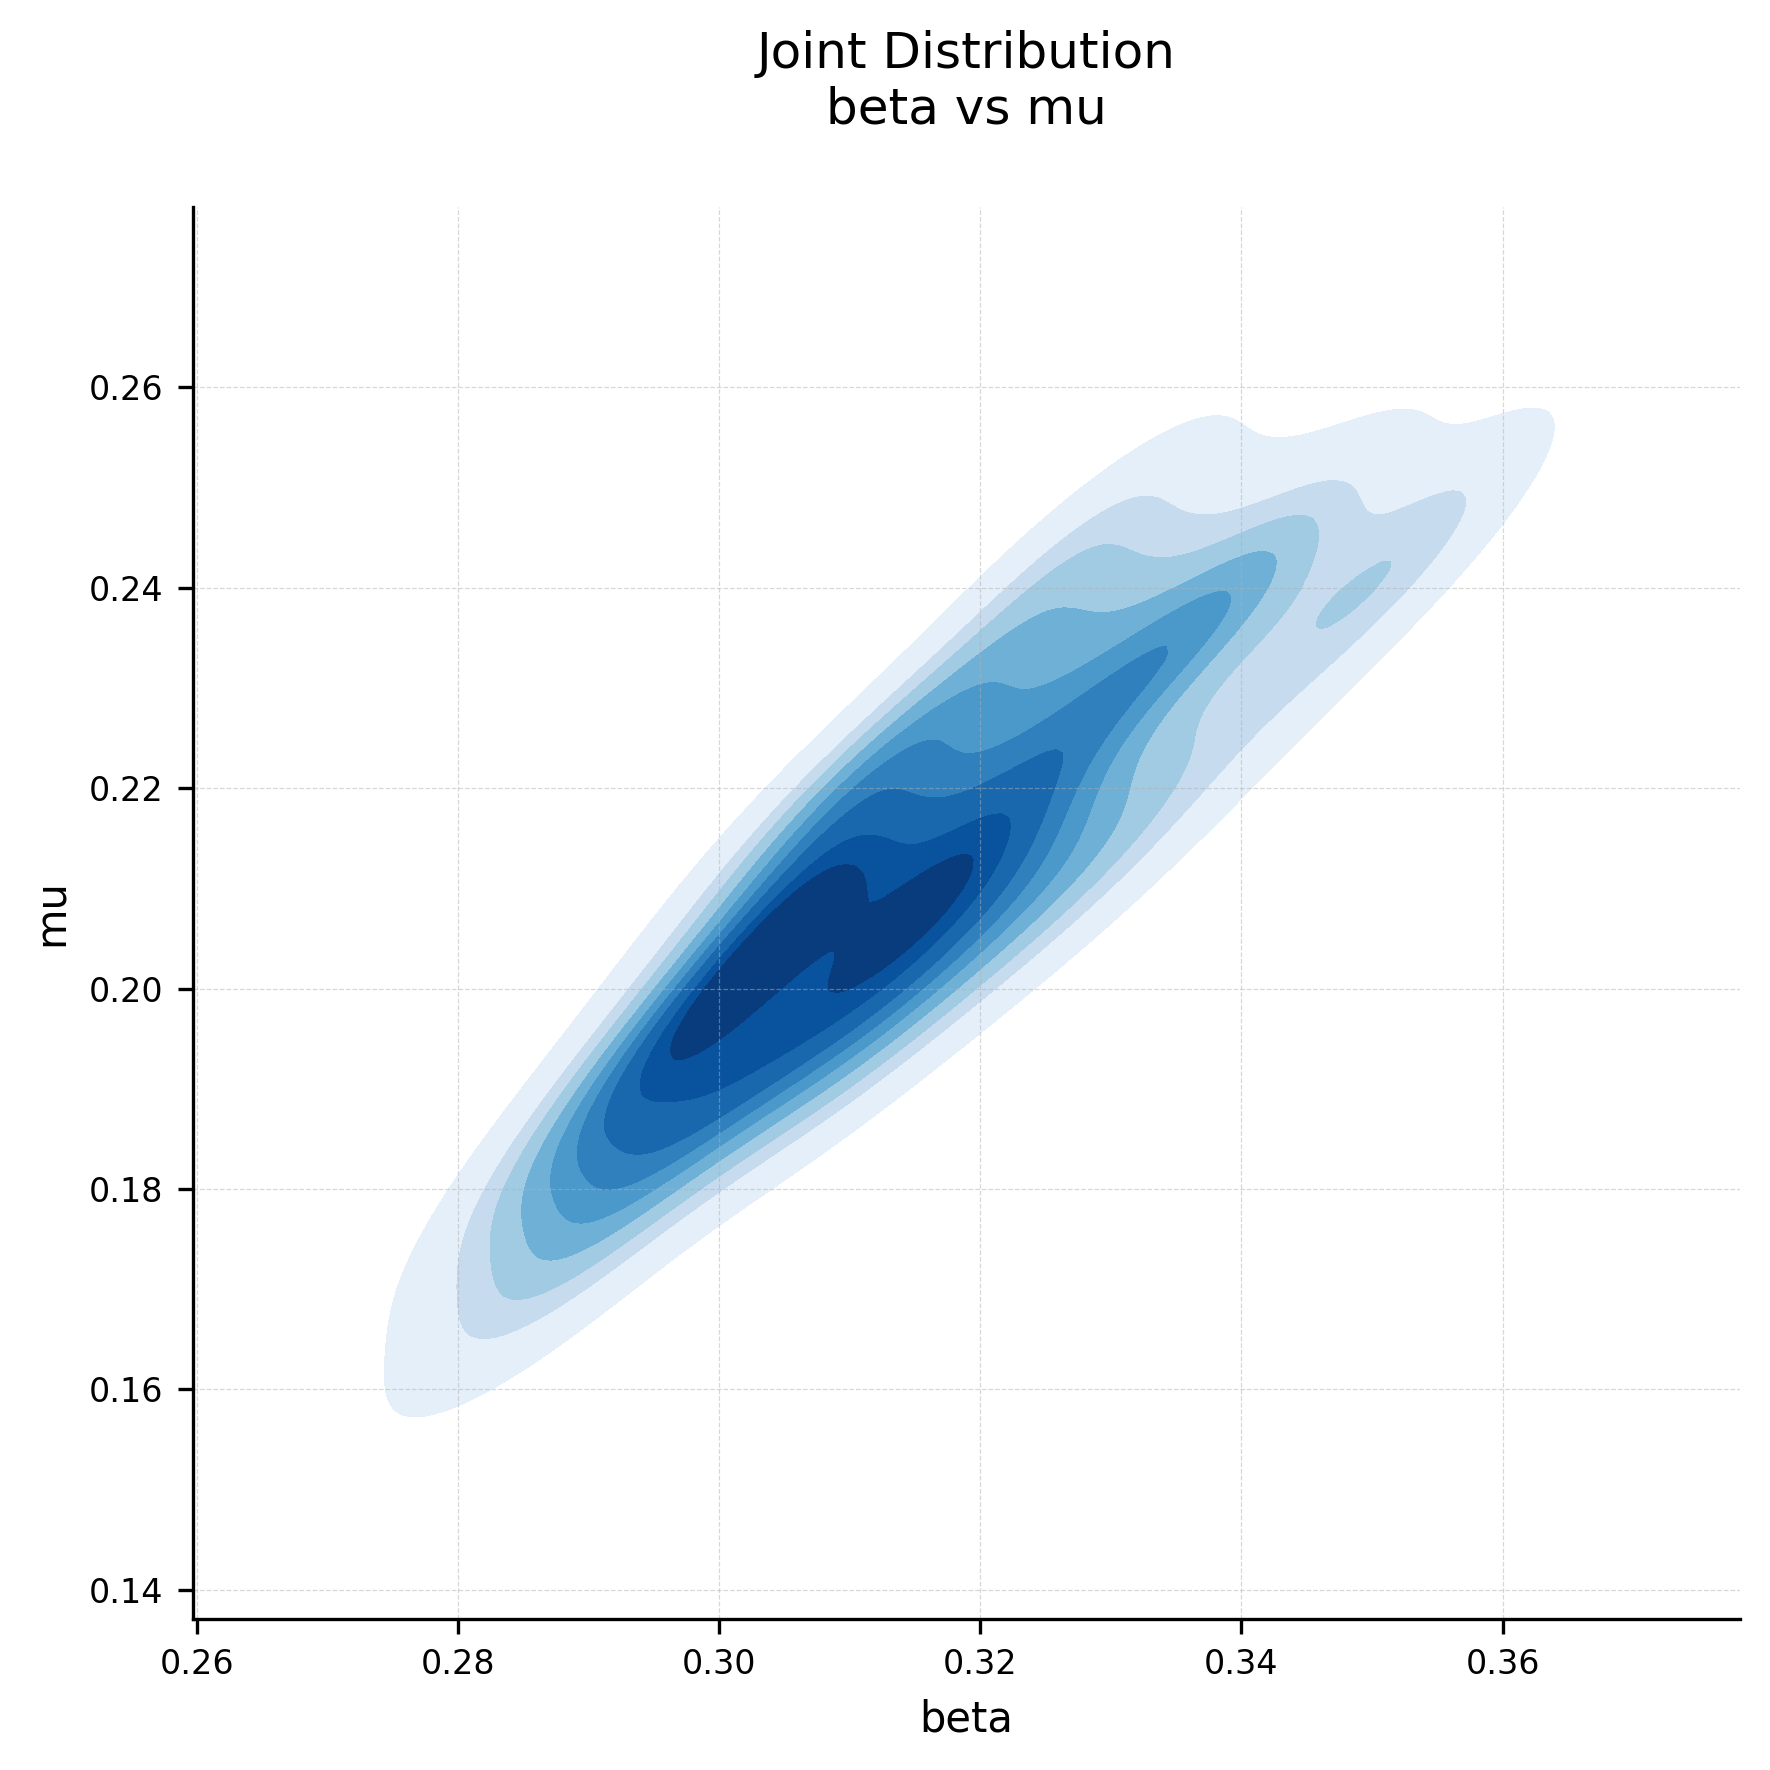

In [12]:
df_posterior = results.get_posterior_distribution()
plot_posterior_distribution_2d(df_posterior, "beta", "mu", kind="kde")